In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact
import joblib
import shap
shap.initjs()
import warnings
import lightgbm as lgb
import pickle
# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
from sklearn.utils.class_weight import compute_class_weight
import MyClassAndFun as MCF

In [2]:
def perform_tests(df):
    # Непрерывные переменные
    transform_var_list = ['age', 'annual_income', 'interest_rate', 'delay_from_due_date', 'changed_credit_limit', 'outstanding_debt', 'credit_utilization_ratio', 'credit_history_monts', 'num_of_delayed_payment', 'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']

    summary = []

    # Хи-квадрат тест для категориальных переменных
    for col in df.columns[:-1]:
        if col in transform_var_list:
            t_stat, pvalue = f_classif(df[[col]], df["credit_score"])
            summary.append([col, t_stat[0], pvalue[0]])
        else :
            cross = pd.crosstab(index=df[col], columns=df["credit_score"])
            t_stat, pvalue, *_ = chi2_contingency(cross)
            summary.append([col, t_stat, pvalue])

    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

In [3]:
df=pd.read_csv('transformed__dumm_train.csv')
df.drop(['id','customer_id','month','ssn_aaa','monthly_inhand_salary','delay_from_due_date'], axis=1, inplace=True)
X=df.drop('credit_score', axis=1)
y=df['credit_score']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1,stratify=y)
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
transform_var_list=['age','annual_income','changed_credit_limit',#'delay_from_due_date',,'interest_rate'
                    'credit_utilization_ratio','credit_history_monts',#'outstanding_debt',
                    'num_of_delayed_payment','total_emi_per_month','amount_invested_monthly','monthly_balance',]
for i in transform_var_list:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_test_df=pd.DataFrame(X_test,columns=X.columns)
combined_df = pd.concat([X_train_df, y_train], axis=1)
test_results = perform_tests(combined_df)
# print(test_results.sort_values(by="t-statistic", ascending=False))
X_test_df=X_test_df[list(test_results.loc[test_results['p-value']==0].column)]
X_train_df=X_train_df[list(test_results.loc[test_results['p-value']==0].column)]
class_labels = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))


In [7]:
# from imblearn.over_sampling import SMOTE
# smapling_strateqy={key:int(value*1.2) for key,value in class_counts.items()}
# smote=SMOTE(sampling_strategy=smapling_strateqy)
# X_test_df,y_test=smote.fit_resample(X_test_df,y_test)

In [20]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state=0)
# path = clf.cost_complexity_pruning_path(X_train_df, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

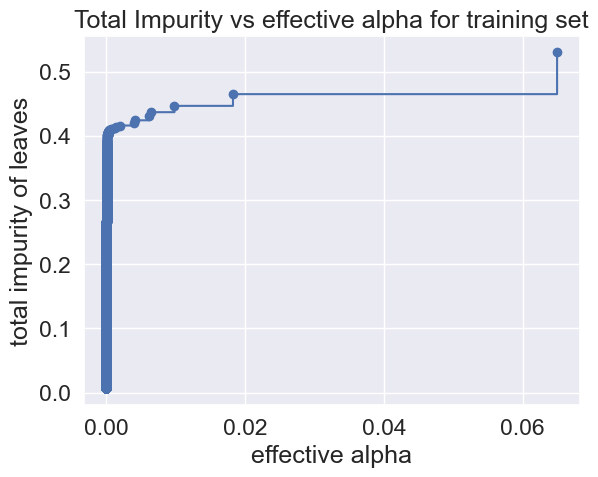

In [21]:
# fig, ax = plt.subplots()
# ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
# ax.set_xlabel("effective alpha")
# ax.set_ylabel("total impurity of leaves")
# ax.set_title("Total Impurity vs effective alpha for training set")

In [23]:
# clfs = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(X_train_df, y_train)
#     clfs.append(clf)
# print(
#     "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#         clfs[-1].tree_.node_count, ccp_alphas[-1]
#     )
# )

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07155108261720655


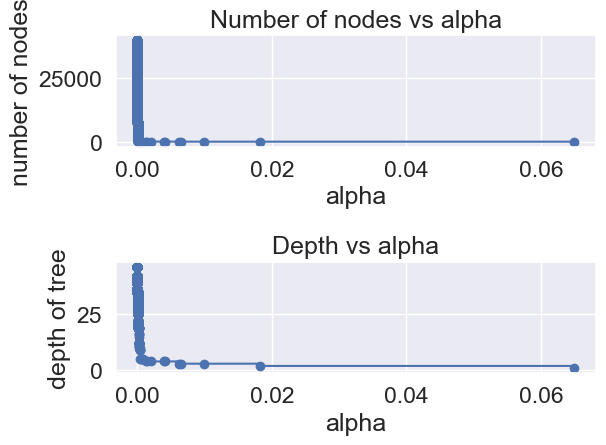

In [24]:
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# node_counts = [clf.tree_.node_count for clf in clfs]
# depth = [clf.tree_.max_depth for clf in clfs]
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
# ax[0].set_xlabel("alpha")
# ax[0].set_ylabel("number of nodes")
# ax[0].set_title("Number of nodes vs alpha")
# ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
# ax[1].set_xlabel("alpha")
# ax[1].set_ylabel("depth of tree")
# ax[1].set_title("Depth vs alpha")
# fig.tight_layout()

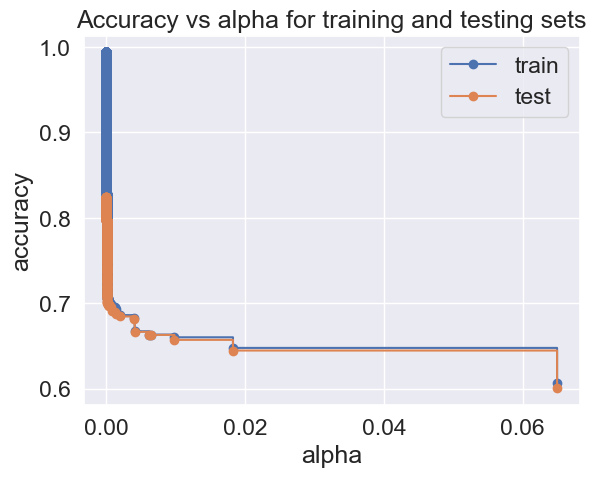

In [25]:
# train_scores = [clf.score(X_train_df, y_train) for clf in clfs]
# test_scores = [clf.score(X_test_df, y_test) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
# ax.legend()
# plt.show()


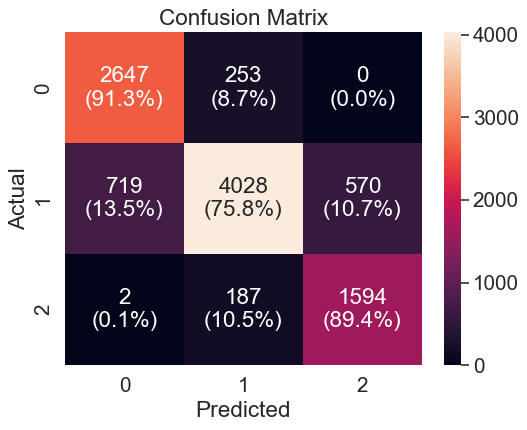

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2900
           1       0.90      0.76      0.82      5317
           2       0.74      0.89      0.81      1783

    accuracy                           0.83     10000
   macro avg       0.81      0.85      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [14]:
Random_Forest_C=RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,criterion='entropy',bootstrap=True,
                        n_estimators=1400)
Random_Forest_C.set_params(random_state=1, n_jobs = -1,class_weight=dict(enumerate(class_weights)))

Random_Forest_C.fit(X_train_df, y_train)
# Saving model
joblib.dump(Random_Forest_C, 'random_forest_model.joblib')
# Loading the model back
# Random_Forest_C = joblib.load('random_forest_model.joblib')

Random_Forest_pred = Random_Forest_C.predict(X_test_df)
confusion = confusion_matrix(y_test, Random_Forest_pred)
report = classification_report(y_test, Random_Forest_pred)

cm = confusion_matrix(y_test, Random_Forest_pred)
cm_norm = confusion_matrix(y_test, Random_Forest_pred, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)
fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=Random_Forest_C.classes_, yticklabels=Random_Forest_C.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print(f"Classification Report for Random Forest Classifier:\n")
print(report)

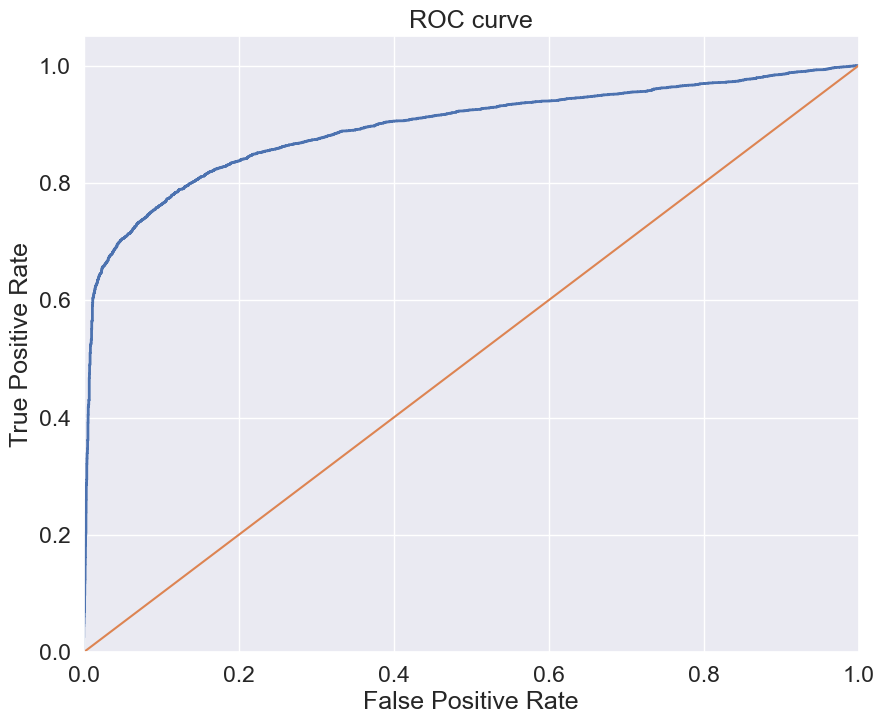

In [15]:
MCF.ROC_curve(Random_Forest_C,X_test_df,y_test)

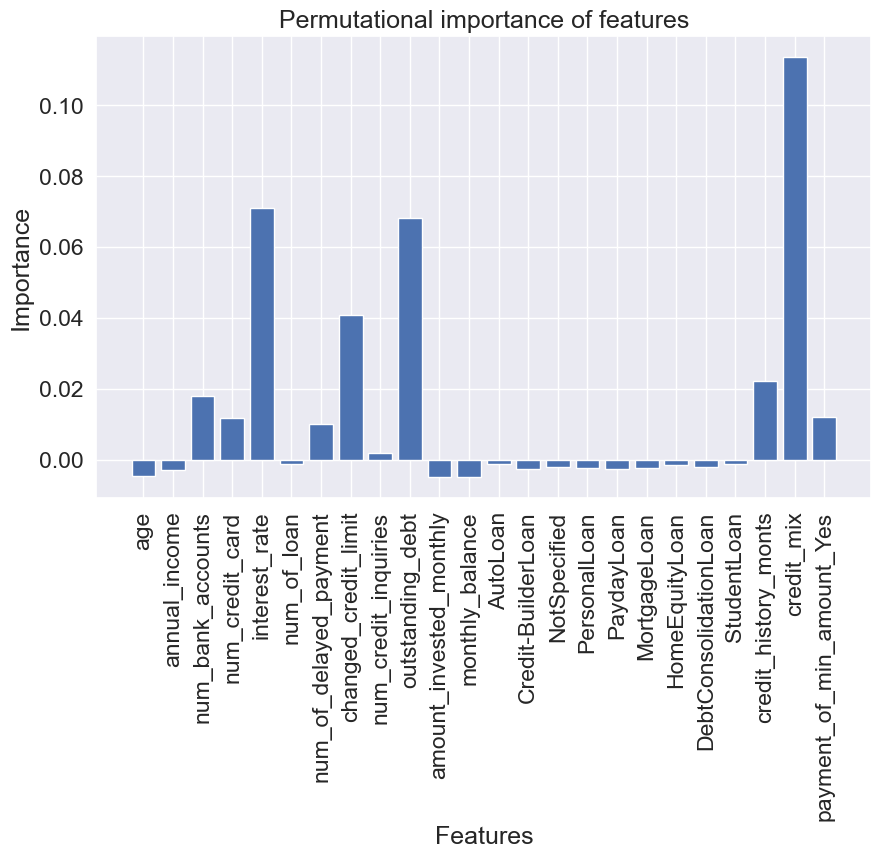

In [16]:
MCF.Perm_import(Random_Forest_C,X_test_df,y_test)

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)  

MCF.plot_learning_curve(Random_Forest_C, X_train_df, y_train, X_test_df, y_test, train_sizes)
